<h1> Trained gradient boosting regression versus linear statistical models.</h1>
This notebook highlights multiple processes that are prevalent in data science: cleaning data, data exploration and visual modeling. It also highlights the difference in computing accuracy between a trained gradient boosting regression model versus linear statistical models.  
<h3>by Angelo Cortez (UC Irvine '17)  </h3>

In [36]:
# Import our needed modules
# numpy and pandas to manipulate the csv's dataframe components
import numpy as np
import pandas as pd

tyo=pd.read_csv('listings.csv')
tyo.dropna(axis=0, how='all', inplace=True)

# Then we import our listings file. We do not want to see blank rows, so we shall delete them with the .dropna method
# We want to see if there are any duplicates in the dataframe. We can achieve this by comparing listing ID's.
# By using the lambda method below, we can extract the id in the URL, then by applying the .drop_duplciates() method,
# we can find delete those with duplicate url's. 

tyo.url = tyo.url.apply(lambda x:str(x).split('?')[0])
tyo = tyo.drop_duplicates(subset=['url'])

# We want to reconstruct the Entire_home/apt feature and the book_instantly with dummy variables. 
# This is achievable by using the .map function.

tyo['Entire_home/apt'] = tyo.room_type.map({'Entire home/apt':1, 'Private room': 0, 'Shared room': 0})
tyo['book_instantly'] = tyo.instant_book.map({True:1, False: 0 })
tyo.drop('instant_book', axis=1, inplace = True)

# We don't need the url feature. 
tyo.drop('url', axis=1, inplace=True)

# We can also take care of dummies using for loops!

booleans=[]
for i in tyo.bed_type:
    if i == 'Real Bed':
        booleans.append(1)
    else:
        booleans.append(0)
tyo['bed_type'] = booleans


# Dropping the cancel policy sice it is uninteresting. 

tyo.drop('cancel_policy',axis=1, inplace=True) 

tyo.drop(0, axis=0, inplace=True)
tyo.drop('room_type', axis=1, inplace = True)
X = tyo.drop(['price','amenities','response_time'], axis=1)
y = tyo.price
# Set X and Y variables here. 


(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5]), <a list of 11 Text xticklabel objects>)

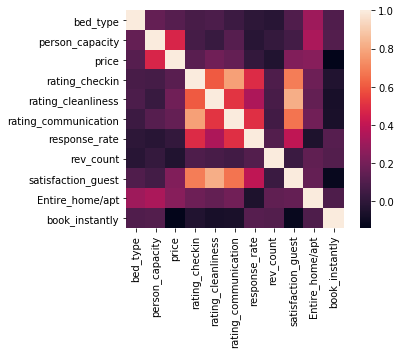

In [43]:
# Below we can see the Pearson's r correlation of the listings data. 
# Pearson's r measures the strength of the linear relationship between two variables. 
# We can see that the most correlated to price is the person capacity of a listing. 

pears= X = tyo.drop(['amenities','response_time'], axis=1)
import seaborn as sns
%matplotlib inline
corr_matrix = pears.corr()
sns.heatmap(corr_matrix, square=True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)

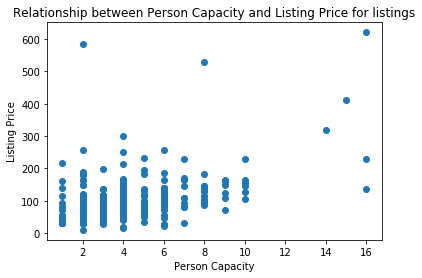

In [44]:
plt.scatter(tyo.person_capacity,tyo.price)
plt.xlabel("Person Capacity")
plt.ylabel("Listing Price")
plt.title("Relationship between Person Capacity and Listing Price for listings")
plt.show()

In [37]:
X.isnull().sum().sort_values(ascending=False).head() 

satisfaction_guest      28
rating_communication    28
rating_cleanliness      28
rating_checkin          28
accuracy                28
dtype: int64

In [32]:
def show_best(grid_pipe):
    print(f'Best params: {grid_pipe.best_params_} \nBest score: {-1*grid_pipe.best_score_}')

In [33]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)


In [34]:
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor

In [44]:

pipeline3 = Pipeline([
    ('imp', Imputer(missing_values='NaN', strategy = 'mean', axis=0)),
    ('rgr', GradientBoostingRegressor())
])

tuned_parameters = {
    "rgr__n_estimators":      [ n for n in range(80,200,10)],
    "rgr__max_depth" :        [ 3  ],
    "rgr__learning_rate":     [   0.1, .05, .15],
    "rgr__min_samples_split" :[  6    ],
    "rgr__loss" :             [ 'ls', 'lad' ],
    "rgr__max_features":      [ 1.0, 0.8,  0.5, 0.3   , 0.1    ]}

noScalePipe = GridSearchCV(pipeline3, tuned_parameters, cv=5, scoring='neg_median_absolute_error')
noScalePipe.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('rgr', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_de...s=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'rgr__n_estimators': [80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190], 'rgr__max_depth': [3], 'rgr__learning_rate': [0.1], 'rgr__min_samples_split': [4, 6, 8], 'rgr__loss': ['ls', 'lad'], 'rgr__max_features': [1.0, 0.8, 0.5, 0.3, 0.1]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_median_absolute_error', verbose=0)

In [45]:
show_best(noScalePipe)

Best params: {'rgr__learning_rate': 0.1, 'rgr__loss': 'lad', 'rgr__max_depth': 3, 'rgr__max_features': 0.5, 'rgr__min_samples_split': 4, 'rgr__n_estimators': 130} 
Best score: 13.865838570478287


Now we instantiate the GBRegressor into a new pipeline so we can extract feature importances from it (scikit-learn deos not allow us to extract feature importances from a gridsearched pipeline). 

In [86]:
gbt = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='lad', max_depth=3, max_features=0.8,
               max_leaf_nodes=None, min_impurity_decrease=0.0,
               min_impurity_split=None, min_samples_leaf=1,
               min_samples_split=6, min_weight_fraction_leaf=0.0,
               n_estimators=180, presort='auto', random_state=None,
               subsample=1.0, verbose=0, warm_start=False)
pipeline = Pipeline([
    ('imp', Imputer(missing_values='NaN', strategy = 'mean', axis=0)),
    ('rgr', gbt)
])
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('rgr', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=3, max_features=0.8,
             max_leaf_nodes=None, min_impurity_de...s=180, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False))])

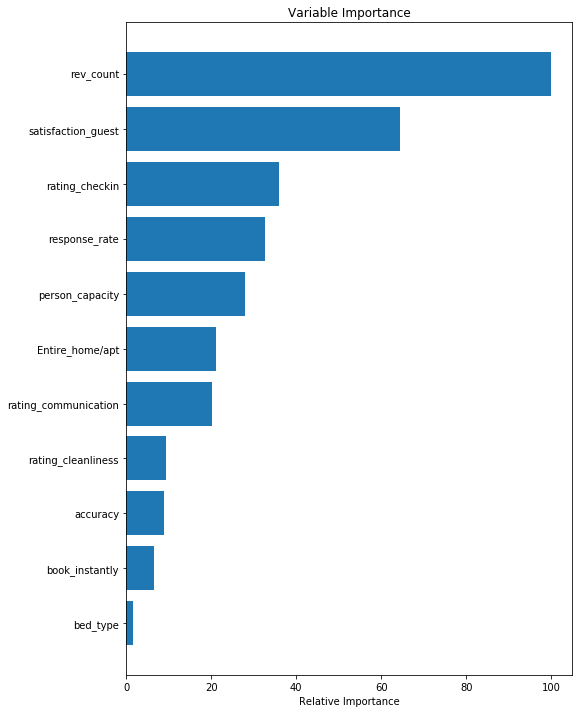

In [87]:
feature_importance = gbt.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
pvals = feature_importance[sorted_idx]
pcols = X_train.columns[sorted_idx]
plt.figure(figsize=(8,12))
plt.barh(pos, pvals, align='center')
plt.yticks(pos, pcols)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')

#As expected, person capacity was the most important variable when predicting price

<li> We can see that the median absolute error was around $13 with the GBRegressor and the most important feature when it came to predicting price was the number of reviews of a listing. Now let's compare it to linear statistical models below.</li>

In [16]:
imp = Imputer(missing_values='NaN', strategy = 'median', axis=0)
imp.fit(X)
X = pd.DataFrame(data=imp.transform(X), columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)


[ 22.43590597  22.2955814   19.09626037  19.42072797  19.69915185
  23.7814173   20.50097775  19.62987255  25.62426754  22.43590597]


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


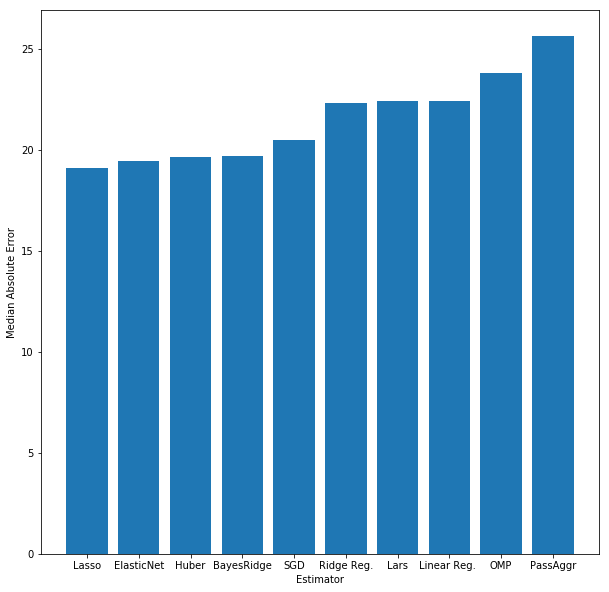

In [29]:
# get median error values using sklearn. 
# use matplotlib to graph the calculations
from sklearn import linear_model
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


%matplotlib inline

rs = 1

ests = [ linear_model.LinearRegression(), linear_model.Ridge(),
        linear_model.Lasso(), linear_model.ElasticNet(),
        linear_model.BayesianRidge(), linear_model.OrthogonalMatchingPursuit(), linear_model.SGDRegressor(),
       linear_model.HuberRegressor(), linear_model.PassiveAggressiveRegressor(), linear_model.Lars()]
ests_labels = np.array(['Linear Reg. ', 'Ridge Reg.', 'Lasso', 'ElasticNet', 'BayesRidge', 'OMP', 'SGD', 
                        'Huber', 'PassAggr', 'Lars'])
errvals = np.array([])


for e in ests:
    e.fit(X_train, y_train)
    this_err = metrics.median_absolute_error(y_test, e.predict(X_test))
    #print "got error %0.2f" % this_err
    errvals = np.append(errvals, this_err)

    
pos = np.arange(errvals.shape[0])
srt = np.argsort(errvals)
plt.figure(figsize=(10,len(ests_labels)))
plt.bar(pos, errvals[srt], align='center')
plt.xticks(pos, ests_labels[srt])
plt.xlabel('Estimator')
plt.ylabel('Median Absolute Error')
print(errvals)

# calculate median error using gradient boosting regression


<li> The graph above shows that other untuned statistical estimators gave us a median absolute error rate of around 21 to 23 dollars. At an error of about 13 dollars, we can conclude that gradient boosting regressor serves as a more accurate estimator.  </li>